In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from astropy.io import ascii
import emcee as emcee
from astropy import constants, units
import os
import corner
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import gaussian_kde
from astropy.visualization import (PercentileInterval, ImageNormalize, AsinhStretch,LinearStretch)
from astropy.io import fits
import seaborn as sns
from matplotlib.patches import Circle
from scipy.signal import argrelextrema
from kneed import KneeLocator

NameError: name 'load_fits_image' is not defined

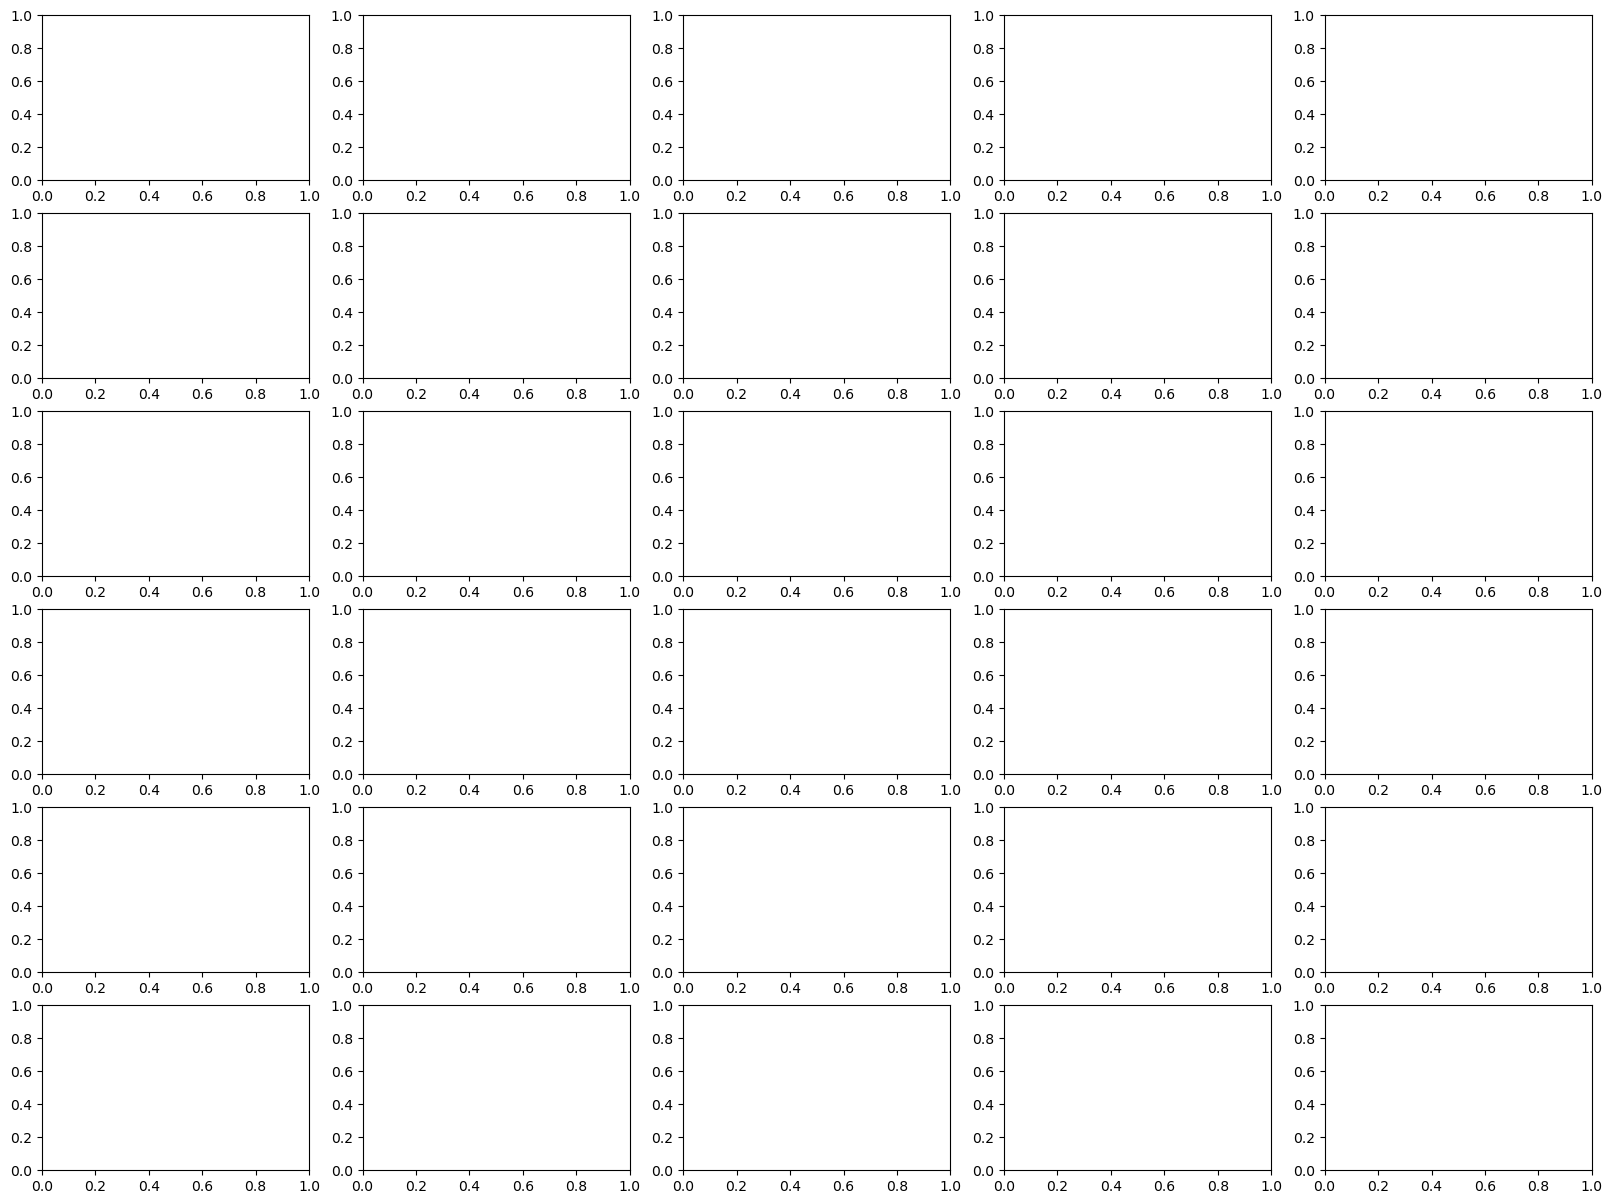

In [8]:


# Plot the images
fig, axes = plt.subplots(nrows=len(bands), ncols=len(calibrations), figsize=(20, 15))

every_band_data = []
for i, band in enumerate(bands):
    filename = ''

    # For color normalization, compute the min/max for each row (band)
    band_images = []
    for j, cal in enumerate(calibrations):
        if band == 'C' or band == 'X':
            cal = cal + '-peeled'

        filename = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'
        image_data, header = load_fits_image(filename)
        band_images.append(image_data)

    # Calculate normalization based on all images in this band
    all_band_data = np.concatenate([img.flatten() for img in band_images])
    vmin, vmax = np.percentile(all_band_data, [1, 100])  # Percentile for color stretch
    fwhm_deg = calculate_fwhm(filename)
    every_band_data.append([img.flatten() for img in band_images])
    # Plot each image
    for j, cal in enumerate(calibrations):
        ax = axes[i, j]
        img = band_images[j]

        # Normalize and stretch the color scale
        norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
        ax.imshow(img, cmap='inferno', origin='lower',norm=norm)


        pixel_scale_deg = np.abs(header['CDELT1'])
        pixel_scale = pixel_scale_deg

        fwhm_pixels = fwhm_deg / pixel_scale
        # print(band, cal,fwhm_deg,pixel_scale)

        # Center the FWHM box on the image
        img_center_x = img.shape[1] // 2
        img_center_y = img.shape[0] // 2
        half_fwhm_pixels = fwhm_pixels / 2

        delta_extent_arcsec = np.array([-half_fwhm_pixels, 0, half_fwhm_pixels]) * pixel_scale*60 


        # Set the plot limits based on FWHM in pixels, centered on the image
        ax.set_xlim(img_center_x - half_fwhm_pixels, img_center_x + half_fwhm_pixels)
        ax.set_ylim(img_center_y - half_fwhm_pixels, img_center_y + half_fwhm_pixels)

        ax.set_xticks([img_center_x - half_fwhm_pixels, img_center_x, img_center_x + half_fwhm_pixels])
        ax.set_xticklabels([f"{x:.1f}'" for x in delta_extent_arcsec])  # Δ" from center
        ax.set_yticks([img_center_y - half_fwhm_pixels, img_center_y, img_center_y + half_fwhm_pixels])
        ax.set_yticklabels([f"{y:.1f}'" for y in delta_extent_arcsec])  # Δ" from center

        # Set title and labels for the first row/column
        if i == 0:
            ax.set_title(f'Cal {cal}')
        if j == 0:
            ax.set_ylabel(f'Band {band}\nFWHM: {fwhm_deg:.2f} deg')

    
plt.tight_layout()
plt.show()


In [9]:
def plot_bands(cutoff=1, bound=-1):
    fig, axs = plt.subplots(6,1,figsize=(15,20))
    bands = ["Q", "A", "K", "U", "X", "C"]
    calibrations = ["0", "1", "1f", "2", "3"]


    absolute_maxes = [max([max(sublist) for sublist in x]) for x in every_band_data]
    print(absolute_maxes)
    for band_num in range(6):
        band_max = absolute_maxes[band_num]
        band_cals = every_band_data[band_num]
        for cal_num in range(5):
            data = band_cals[cal_num]
            if data.dtype.byteorder == '>':  # Big-endian
                data = data.byteswap().newbyteorder()
            data /= band_max
            # make any cuts
            if bound < 0:
                data = data[data < cutoff]
            if bound > 0:
                data = data[data > cutoff]

            kde = gaussian_kde(data)
            x_vals = np.linspace(min(data), max(data), 1000)  # Generate x values
            y_vals = kde(x_vals)
            axs[band_num].plot(x_vals, y_vals, label=calibrations[cal_num])


        axs[band_num].set_title(bands[band_num] + " Band")
        axs[band_num].set_xlabel("Intensity")
        axs[band_num].set_ylabel("Density")
        axs[band_num].legend()
        # axs[band_num].set_yscale('log')


    plt.subplots_adjust(hspace=1)

# Constants
D = 25  # Antenna diameter in meters
c = 3e8  # Speed of light in m/s

# Function to calculate FWHM (lambda/D)
def calculate_fwhm(fits_filename):
    with fits.open(fits_filename) as hdul:
        header = hdul[0].header

        # Extract the frequency (assuming it's in Hz in CRVAL3 or a similar keyword)
        frequency_hz = header.get('CRVAL3')  # Adjust the keyword if necessary

    wavelength = c / frequency_hz  # Wavelength in meters
    fwhm = wavelength / D  # FWHM in radians
    fwhm_deg = np.degrees(fwhm)  # Convert to degrees
    return fwhm_deg

# Frequency mapping for VLA bands (center frequencies in Hz)
band_frequencies = {
    "Q": 45e9,
    "A": 43e9,
    "K": 24e9,
    "U": 15e9,
    "X": 8.4e9,
    "C": 5e9,
}

# Files template: MWC480_{band}.contp{calibration}.image.tt0.fits
bands = ["Q", "A", "K", "U", "X", "C"]
calibrations = ["0", "1", "1f", "2", "3"]

# Function to load the image data and header
def load_fits_image(filename):
    with fits.open(filename) as hdul:
        image_data = hdul[0].data.squeeze()  # Assuming the image is in the primary HDU
        header = hdul[0].header
    return image_data, header


[0.0034656252, 0.001651272, 0.0008560724, 0.00044998172, 0.00031715972, 0.0002803063]


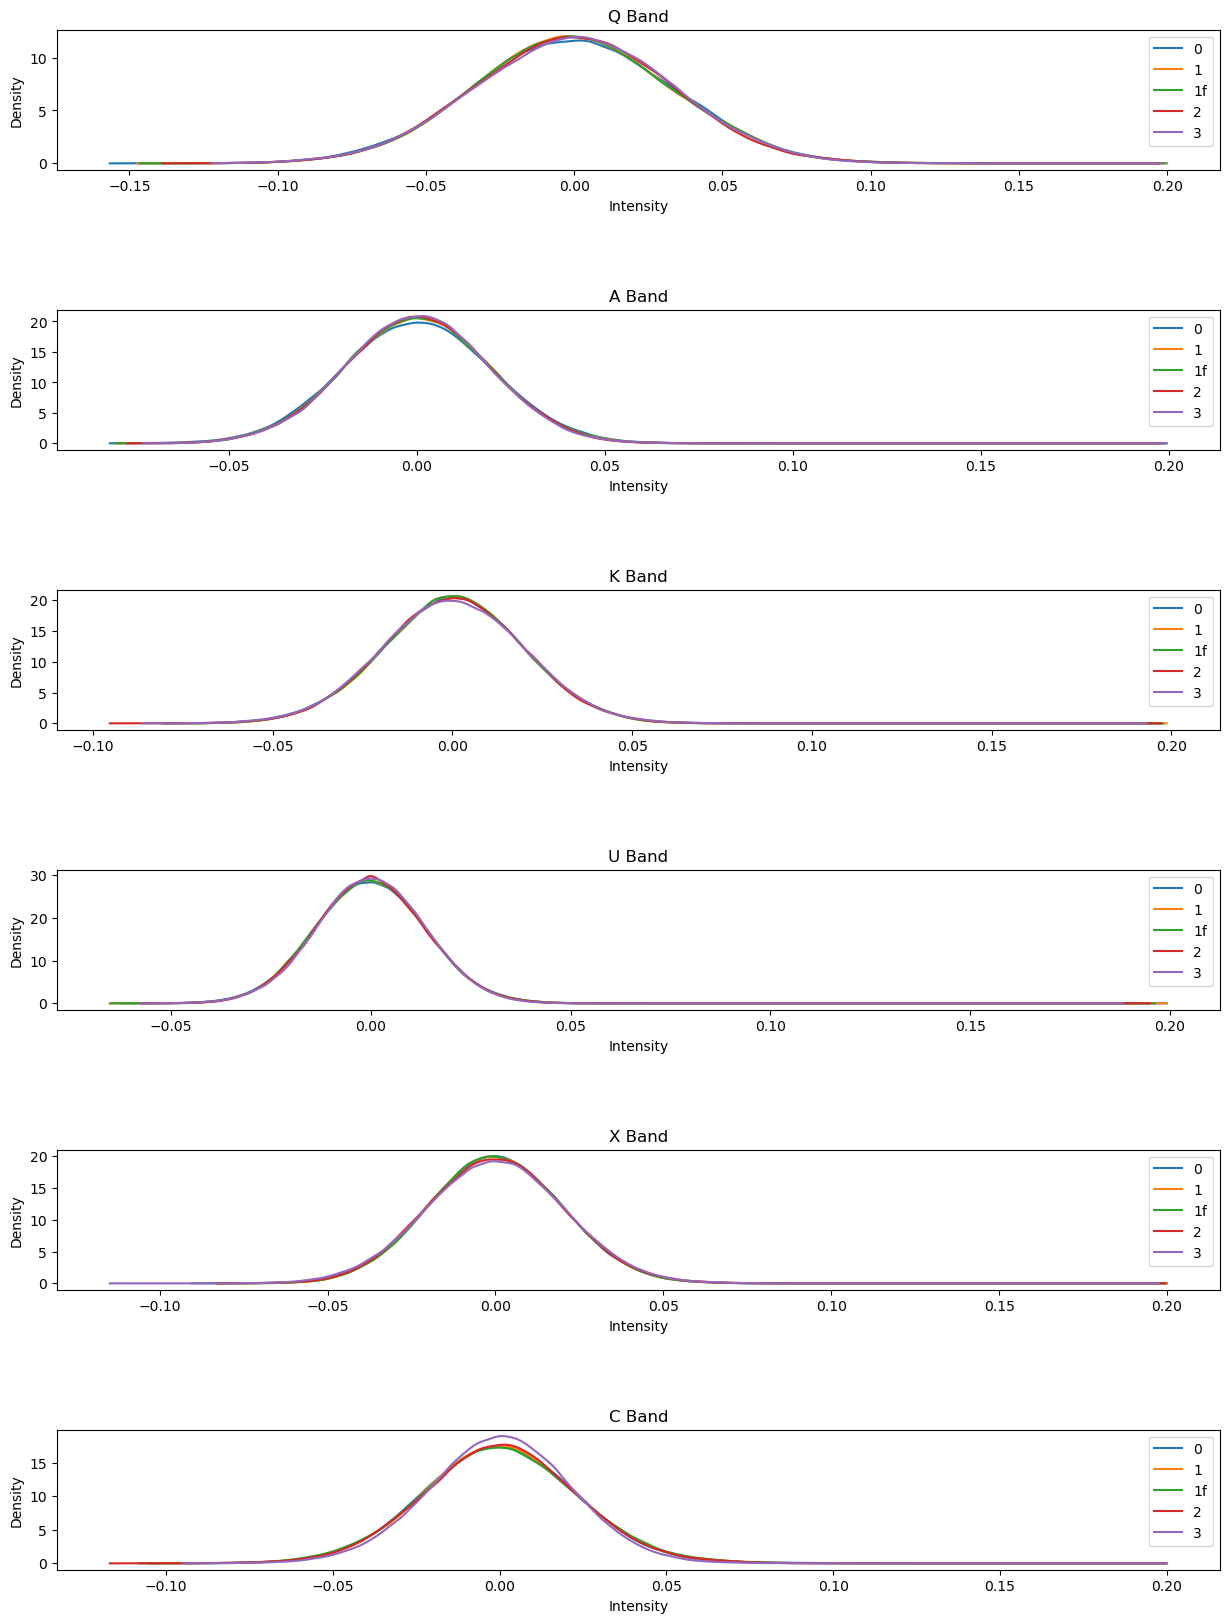

In [17]:
## only noise
plot_bands(cutoff=.2)

## Calculate Radius

In [19]:
def cumulative_flux(data, max_radius):
    center_x, center_y = np.unravel_index(np.argmax(data), data.shape)
    center_x, center_y = int(data.shape[0]/2), int(data.shape[1]/2)

    radii = np.arange(1, max_radius + 1)
    cumulative_flux = [0]
    fractional_increases = []

    # Create a coordinate grid
    y, x = np.indices(data.shape)
    distances = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    for r in radii:
        # Mask for pixels within the current radius
        mask = distances <= r
        flux = np.sum(data[mask])
        fractional_increases.append(abs(flux-cumulative_flux[-1]))
        cumulative_flux.append(flux)
        
    cumulative_flux = cumulative_flux[1:] 

    radii_new = np.arange(1, max_radius + 1,.1)
    cumulative_flux = np.interp(radii_new, radii, cumulative_flux)
    fractional_increases = np.interp(radii_new, radii, fractional_increases)

    return radii_new, cumulative_flux, fractional_increases



def plot(data, header, max_ring,ax,cal):

    plt.figure(figsize=(10, 10))
    center_x, center_y = int(data.shape[0]/2), int(data.shape[1]/2)

    pixel_scale_arcsecond = np.abs(header['CDELT1']) * 3600
    viewsize_pixels = 70

    vmin, vmax = np.percentile(data, [1, 100]) 
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    # ax.imshow(data[center_x-viewsize_pixels:center_x+viewsize_pixels, center_y-viewsize_pixels:center_y+viewsize_pixels], cmap='inferno', origin='lower',norm=norm,extent=(-viewsize_pixels*pixel_scale_arcsecond, viewsize_pixels*pixel_scale_arcsecond,-viewsize_pixels*pixel_scale_arcsecond, viewsize_pixels*pixel_scale_arcsecond))
    ax.imshow(data[center_x-viewsize_pixels:center_x+viewsize_pixels, center_y-viewsize_pixels:center_y+viewsize_pixels], cmap='inferno', origin='lower',norm=norm)

    # Mark the center
    ax.scatter(0, 0, color='black', s=10, marker='x', label='Center (Brightest Point)')
    ax.text(.05,.9,f'Cal {cal}',color='white',transform=ax.transAxes)
    # Draw a few representative rings
    # radii = [20, 50]  # Adjust these radii based on your needs
    # for r in radii:
    #     circle = Circle((center_x, center_y), r, color='cyan', fill=False, linestyle='--', linewidth=1.5)
    #     plt.gca().add_patch(circle)
    #     plt.text(center_x + r, center_y, f'R={r}', color='cyan', fontsize=12)

    circle = Circle((viewsize_pixels, viewsize_pixels), max_ring, color='cyan', fill=False, linestyle='--', linewidth=1)
    ax.add_patch(circle)


    # Add labels and legend
    ax.set_xlabel(r'$\delta$ RA ["]')
    ax.set_ylabel(r'$\delta$ DEC ["]')
    ax.grid(False)


def plot_profile(radii, header, flux_values,fracs, ax,guess,method):
    pixel_scale_arcsecond = np.abs(header['CDELT1']) * 3600

    # Plot the cumulative flux vs. radius
    radii_arcsec = radii*pixel_scale_arcsecond
    ax.plot(radii_arcsec, flux_values,zorder=1)
    # ax.scatter(radii_arcsec, flux_values,s=5,zorder=1)

    max_ring_index = np.argmax(flux_values)


    max_ring_index = np.argmin(fracs[:len(radii_arcsec[radii_arcsec <guess[1]])])

    if method == 'knee':
        guess_radii = radii_arcsec[len(radii_arcsec[radii_arcsec <guess[0]]):len(radii_arcsec[radii_arcsec <guess[1]])]
        guess_fracs = fracs[len(radii_arcsec[radii_arcsec <guess[0]]):len(radii_arcsec[radii_arcsec <guess[1]])]
        kneedle = KneeLocator(guess_radii, guess_fracs, curve='convex', direction='decreasing')
        max_ring_index = np.where(radii_arcsec == kneedle.elbow)[0][0]

    max_ring = radii[max_ring_index]
    max_ring_arsec = np.round(max_ring*pixel_scale_arcsecond,2)



    ax.axvline(x=max_ring_arsec,color='black',alpha=.5,ls='--',label=f'Radius={max_ring_arsec}"')
    ax.scatter(max_ring_arsec,flux_values[max_ring_index],color='black',alpha=.8,marker='d',s=50)


    ax1 = ax.twinx()
    ax1.plot(radii_arcsec,fracs,color='tab:red',alpha=.5,zorder=0)
    # ax1.scatter(radii_arcsec,fracs,color='tab:red',alpha=.5,zorder=0,s=5)

    ax1.axhline(y=.001,color='tab:red',alpha=.5,zorder=0,ls='--')
    ax1.set_ylabel("Radial Flux Gain")

    ax.set_xlabel('Radius (")')
    ax.set_ylabel('Cumulative Flux')
    ax.grid(True)
    ax.legend(loc='upper right')

    return max_ring, max_ring_arsec
    

In [6]:
bands = ["Q", "A", "K", "U", "X", "C"]
calibrations = ["0", "1", "1f", "2", "3"]
methods = ['knee','min']

band, cal = bands[0],calibrations[4]
fits_file = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'

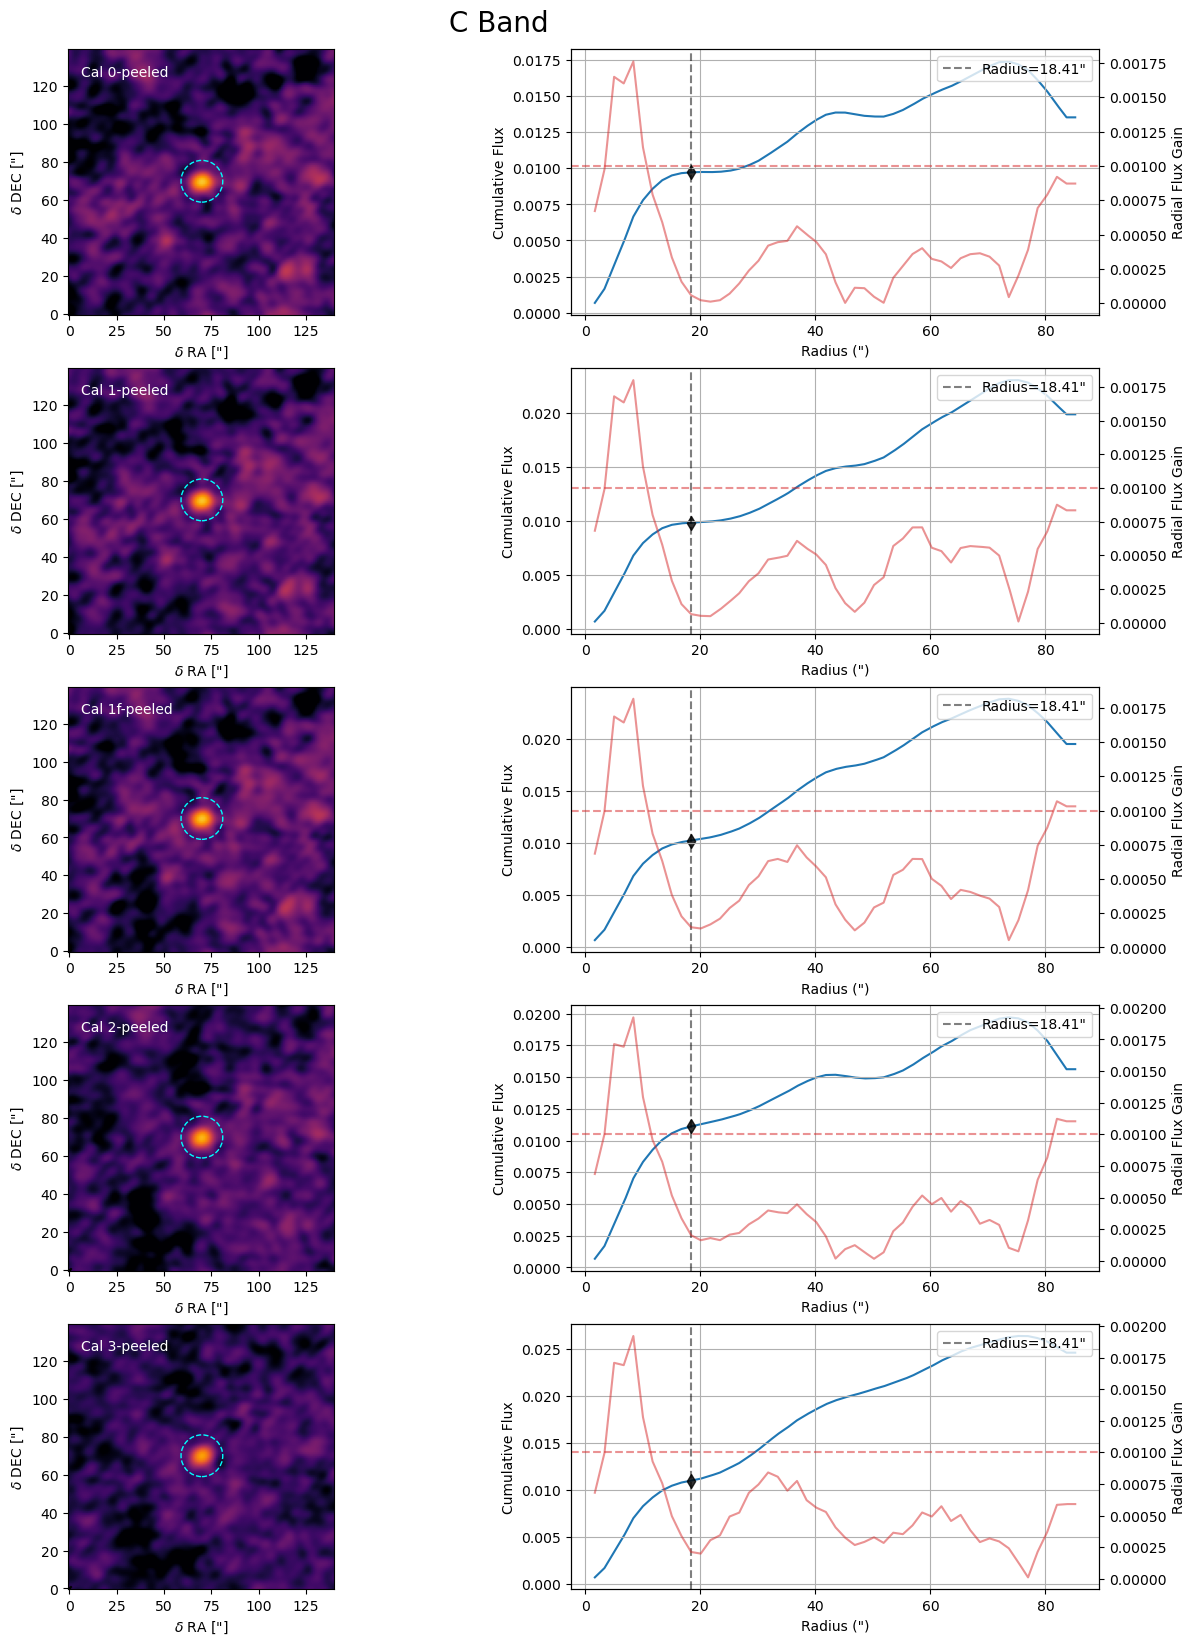

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [20]:
band = bands[5]
guess = (15,30)
method = methods[0]
max_rings = []
fig, all_axs = plt.subplots(5,2, figsize=(15,20))
for n,cal in enumerate(calibrations):
    if band == 'C' or band == 'X':
        cal = cal + '-peeled'


    axs = all_axs[n,:]
    fits_file = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'
    data, header = load_fits_image(fits_file)
    data = np.squeeze(data)
    # Find the brightest point (maximum value)

    max_radius = 50  # in pixels

    # Calculate cumulative flux
    radii, flux_values, fractional_increasers = cumulative_flux(data, max_radius)
    max_ring_np, max_ring = plot_profile(radii,header,flux_values,fractional_increasers,axs[1],guess,method)
    plot(data,header,max_ring_np,axs[0],cal)
    max_rings.append((max_ring_np,max_ring))
    
plt.subplots_adjust(wspace=0,hspace=.3)
fig.suptitle(f"{band} Band", y=.9,fontsize=20)
plt.tight_layout()
fig.savefig(f'/Users/calebpainter/Downloads/research/Disks/plots/{band}_Band_sizes_method_{method}.png')

# plt.show()



In [27]:
bands = ["Q", "A", "K", "U", "X", "C"]

band_radii_arcsec = [3.32, 4.31, 5.64, 8.11, 13.4, 18.41]

calibrations = ["0", "1", "1f", "2", "3"]

In [82]:
print(repr(header))

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  750                                                  
NAXIS2  =                  750                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   4.159362845951E-03                                                  
BMIN    =   3.506424427032E-03                                                  
BPA     =  -7.628667449951E+

ring 225


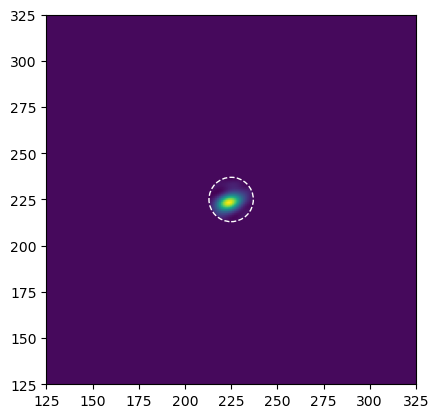

bmaj (2.94893527030956, 1.72930192947396)
0.2985574 75.53090546005167
ring 240


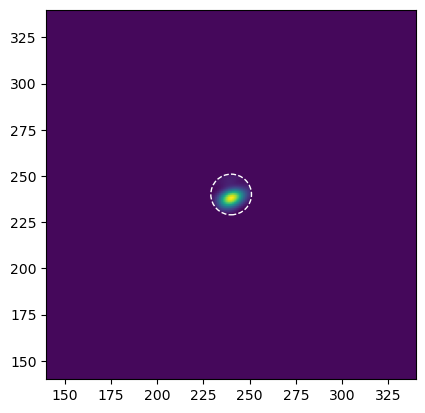

bmaj (3.8744602203384, 2.48445272445696)
0.14688724 84.45635932337835
ring 270


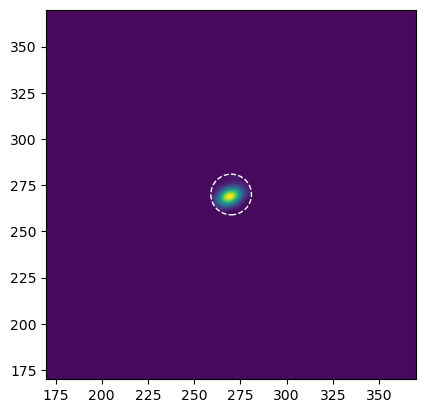

bmaj (5.5901241302508, 3.653364658356)
0.074314974 88.14812285004874
ring 288


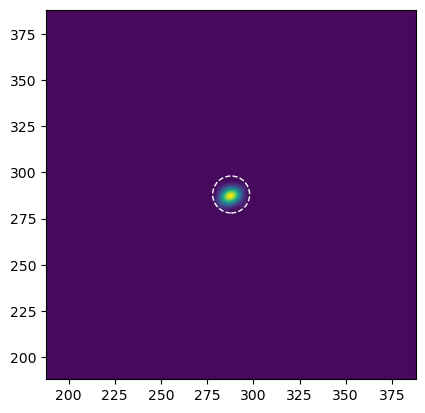

bmaj (6.6066837310799995, 5.0870881080612005)
0.0324239 70.0136998278196
ring 288


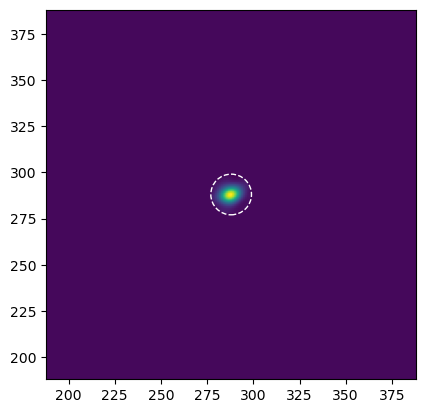

bmaj (10.0424766540528, 7.5994338989268)
0.02417446 69.33452220188745
ring 375


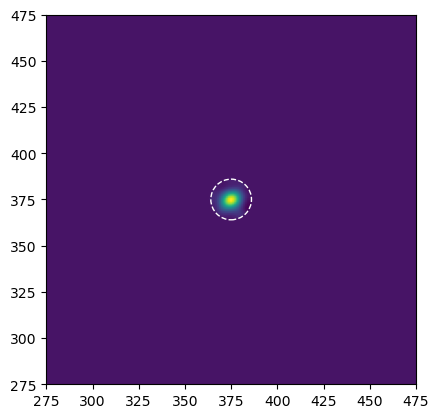

bmaj (14.9737062454236, 12.6231279373152)
0.011008108 76.483338631133


In [85]:
cumulative_flux = []
freqs_ghz = []
for n,band in enumerate(bands):
    cal = '3'
    if band == 'C' or band == 'X':
        cal = cal + '-peeled'

    fits_file = f'/Users/calebpainter/Downloads/research/Disks/data/images_caleb/MWC480_{band}.contp{cal}.image.tt0.fits'
    data, header = load_fits_image(fits_file)
    pixel_scale_arcsecond = np.abs(header['CDELT1']) * 3600


    data = np.squeeze(data)

    band_ring = band_radii_arcsec[n]
    band_ring_pixels = int(band_ring / pixel_scale_arcsecond)

    center = int(len(data[0])/2)
        # Create a coordinate grid
    y, x = np.indices(data.shape)


    distances = np.sqrt((x - center)**2 + (y - center)**2)

    mask = distances <= band_ring_pixels
    data[~mask] *= 0

    flux = np.sum(data[mask])

    print('ring', center)
    circle = Circle((center, center), band_ring_pixels, color='white', fill=False, linestyle='--', linewidth=1)

    viewsize = 100
    plt.imshow(data)
    plt.xlim(center-viewsize, center+viewsize)
    plt.ylim(center-viewsize, center+viewsize)

    plt.gca().add_patch(circle)
    plt.show()

    frequency_hz = header.get('CRVAL3')  # Adjust the keyword if necessary
    bmaj = header.get('BMAJ')  # Major axis in degrees
    bmin = header.get('BMIN')  # Minor axis in degrees

    bmaj *= 3600
    bmin *= 3600
    print('bmaj',(bmaj,bmin))

    bmaj /= pixel_scale_arcsecond
    bmin /= pixel_scale_arcsecond


    if bmaj is not None and bmin is not None:
        beam_area_steradians = (np.pi * (bmaj * bmin)) / (4 * np.log(2))
    
    print(flux, beam_area_steradians)
    flux_micro_jansky = flux*10**6 / beam_area_steradians

    cumulative_flux.append(flux_micro_jansky)
    freqs_ghz.append(frequency_hz/(10**9))



In [93]:
dir_name = '/Users/calebpainter/Downloads/research/Disks/data/'
image_files = os.listdir('/Users/calebpainter/Downloads/research/Disks/data/image')
file_number = 5

image_np= np.load(dir_name+f'/image/{image_files[file_number]}')
nu_img, Snu_img, err_Snu_img = image_np['nu'], image_np['Snu'], image_np['eSnu']



Text(0, 0.5, 'Intensity [uJy]')

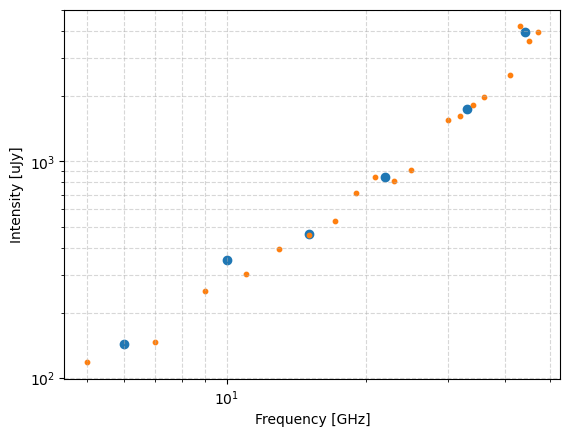

In [96]:
plt.scatter(freqs_ghz,cumulative_flux)
plt.scatter(nu_img,Snu_img*10**6,s=10)

plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.5, ls='--',which='both')
plt.xlabel("Frequency [GHz]")
plt.ylabel("Intensity [uJy]")